In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
datetime.now()

datetime.datetime(2020, 2, 12, 19, 9, 0, 113427)

In [3]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [4]:
url = 'https://ncov.dxy.cn/ncovh5/view/pneumonia'
driver.get(url)

### Extract date

In [5]:
content = driver.page_source
soup =BeautifulSoup(content, 'lxml')


In [6]:
data = soup.findAll(text=re.compile("截至 .+"))
data

['try { window.getIndexRumorList = [{"id":144,"title":"把某些药物敷在脚底可以防病毒？","mainSummary":"丁香医生团队辟谣：到目前为止，还没有专门用于预防和治疗新冠病毒的药物","summary":"","body":"有传闻某药方打粉和蛋清调匀，敷于双脚底涌泉穴。平躺 16 小时，期间不能坐，不能站。口含咬破大蒜一天一夜。可以考虑戴成人尿不湿。晚上开始敷，16 小时内可以不用吃饭。可抑制病毒 / 治疗肺炎。丁香医生再次强调，到目前为止，还没有专门用于预防和治疗新冠病毒的药物。别浪费钱折腾了，少出门，勤洗手，做好家居外出防护，才是最好的方法。","sourceUrl":"","score":1000,"rumorType":0},{"id":145,"title":"候鸟迁徙会携带传播新冠病毒？","mainSummary":"剑桥大学病毒学助理研究员韩越：相比哺乳动物，鱼类、鸟类和爬行类成为新冠肺炎中间宿主的可能性非常小","summary":"","body":"相比于哺乳动物，鱼类、鸟类和爬行类成为新冠肺炎中间宿主的可能性非常小。新冠病毒主要利用细胞表面受体 ACE2 感染哺乳动物，鸟类目前没有被检测出具备大量 ACE2 受体，被病毒侵染概率很低。","sourceUrl":"","score":144,"rumorType":0},{"id":143,"title":"新冠病毒的疫苗研制要 18 个月？","mainSummary":"世卫组织总干事谭德塞博士：开发疫苗和疗法需要时间","summary":"","body":"世卫组织总干事谭德塞博士表示：「开发疫苗和疗法需要时间，与此同时，我们也不是束手无策。我们现在可以采用许多基本公共卫生干预措施预防感染。第一支疫苗可能在 18 个月后才能投入使用。所以，在筹划长远安排的同时，我们今天必须全力使用现有各种武器对付这一病毒。」","sourceUrl":"","score":143,"rumorType":1},{"id":141,"title":"深呼吸再憋十秒可测是否有肺炎？","mainSummary":"丁香医生团队辟谣：真没必要用这样的方式去检查有没有肺炎","summary":"","body":"有肺炎的话，你会咳嗽、呼吸急

In [7]:
for s in data:
    m = re.search("截至 (202\d-\d+-\d+ \d+:\d+)", s)
    if m is not None:
        data_date_time = m.group(1)
data_date_time

'2020-02-12 16:56'

### Extract data (summary)

In [8]:
data = soup.findAll(text=re.compile('\"summary.+\"confirmedCount\":\d'))

data


['try { window.getStatisticsService = {"id":1,"createTime":1579537899000,"modifyTime":1581526610000,"infectSource":"该字段已替换为说明2","passWay":"该字段已替换为说明3","imgUrl":"https://img1.dxycdn.com/2020/0201/450/3394153392393266839-135.png","dailyPic":"https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png,https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png,https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png,https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png,https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png,https://img1.dxycdn.com/2020/0211/089/3395998939840182072-135.png","dailyPics":["https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png","https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png","https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png","https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png","https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png","https://i

In [9]:
m = re.search('\"confirmedCount\":(\d+)', data[0])
summary_confirmed_count = int(m.group(1))


m = re.search('\"curedCount\":(\d+)', data[0])
summary_cured_count = int(m.group(1))

m = re.search('\"deadCount\":(\d+)', data[0])
summary_dead_count = int(m.group(1))


In [10]:
# make a dataframe
df = pd.DataFrame({
    'datetime': data_date_time,
    'confirmed': summary_confirmed_count,
    'cured': summary_cured_count,
    'dead': summary_dead_count
}, index=[0])
df

,datetime,confirmed,cured,dead
0,2020-02-12 16:56,44765,5066,1117


### Save to file

In [11]:
from pathlib import Path
csv_file = 'data/china-summary-cases.csv'

if Path(csv_file).exists():
    # read out the old data - then merge with new data and remove duplicates based on datetime
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)

In [12]:
df.sort_values(by=['datetime'], inplace=True)

df.to_csv(csv_file, index=False)


### Plot graph

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = 'images/china-summary-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

df.set_index('datetime_idx', inplace=True)
df.drop(['datetime'], axis=1, inplace=True)


In [14]:
df

,confirmed,cured,dead
datetime_idx,,,
2020-02-02 10:22:00,14483,379,304
2020-02-02 10:28:00,14483,380,304
2020-02-02 11:19:00,14489,385,304
2020-02-02 11:54:00,14489,397,304
2020-02-02 15:01:00,14490,430,304
...,...,...,...
2020-02-12 11:44:00,44763,5007,1115
2020-02-12 12:40:00,44763,5034,1115
2020-02-12 14:06:00,44763,5064,1116


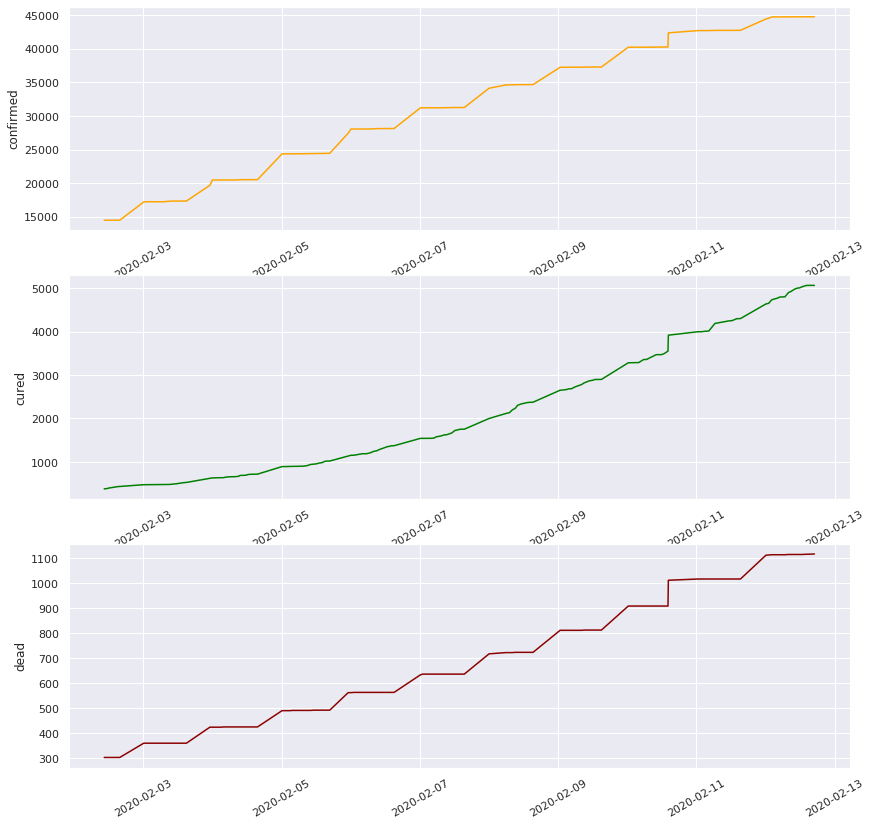

In [15]:
if df.shape[0]>1:
    # line chart when having at least a few points
    sns.set(rc={'figure.figsize':(14,14)})

    fig, axs = plt.subplots(nrows=3)

    sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
    sns.lineplot(x=df.index, y = 'cured', data=df, ax= axs[1], estimator=None, color='green')
    sns.lineplot(x=df.index, y = 'dead', data=df, ax= axs[2], estimator=None, color='darkred')

    for ax in axs:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
else:

    ax = df.plot(kind='bar', stacked=True, figsize=(9,6))
    fig = ax.get_figure()
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(0) 


In [16]:
fig.savefig(png_file)